In [1]:
!git clone https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection

Cloning into 'a-PyTorch-Tutorial-to-Object-Detection'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 249 (delta 59), reused 55 (delta 55), pack-reused 181
Receiving objects: 100% (249/249), 175.95 MiB | 31.56 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [3]:
ls

__notebook_source__.ipynb  a-PyTorch-Tutorial-to-Object-Detection/


In [13]:
%ls

input/  lib/  working/


In [2]:
cd ..

/kaggle


In [15]:
!cp -r ./input/weapon-detection-pascal-voc/* ./working/a-PyTorch-Tutorial-to-Object-Detection/

In [3]:
cd ./working/a-PyTorch-Tutorial-to-Object-Detection

/kaggle/working/a-PyTorch-Tutorial-to-Object-Detection


In [18]:
%ls

LICENSE    create_data_lists.py  detect.py  img/      train.py  voc/
README.md  datasets.py           eval.py    model.py  utils.py


/kaggle/working/a-PyTorch-Tutorial-to-Object-Detection


In [33]:
%%writefile create_data_lists.py
from utils import create_data_lists

if __name__ == '__main__':
    create_data_lists(voc07_path='voc',
                      voc12_path='voc',
                      output_folder='./')


Overwriting create_data_lists.py


In [26]:
ls

LICENSE    __pycache__/          datasets.py  eval.py  model.py  utils.py
README.md  create_data_lists.py  detect.py    img/     train.py  voc/


In [34]:
!python create_data_lists.py


There are 872 training images containing a total of 2616 objects. Files have been saved to /kaggle/working/a-PyTorch-Tutorial-to-Object-Detection.

There are 177 test images containing a total of 531 objects. Files have been saved to /kaggle/working/a-PyTorch-Tutorial-to-Object-Detection.


In [35]:
!ls

LICENSE            TRAIN_images.json     datasets.py  label_map.json  voc/
README.md          TRAIN_objects.json    detect.py    model.py
TEST_images.json   __pycache__/          eval.py      train.py
TEST_objects.json  create_data_lists.py  img/         utils.py


In [36]:
!cp TRAIN_images.json voc/

In [37]:
!cp TRAIN_objects.json voc/

In [38]:
!cp TEST_images.json voc/

In [39]:
!cp TEST_objects.json voc/

In [85]:
%%writefile train.py
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from model import SSD300, MultiBoxLoss
from datasets import PascalVOCDataset
from utils import *

# Data parameters
data_folder = './voc'  # folder with data files
keep_difficult = True  # use objects considered difficult to detect?

# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = len(label_map)  # number of different types of objects
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 8  # batch size
iterations = 28000  # number of iterations to train
workers = 4  # number of workers for loading data in the DataLoader
print_freq = 200  # print training status every __ batches
lr = 1e-3  # learning rate
decay_lr_at = [16000, 22000]  # decay learning rate after these many iterations
decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True


def main():
    """
    Training.
    """
    global start_epoch, label_map, epoch, checkpoint, decay_lr_at

    # Initialize model or load checkpoint
    if checkpoint is None:
        start_epoch = 0
        model = SSD300(n_classes=n_classes)
        # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
        biases = list()
        not_biases = list()
        for param_name, param in model.named_parameters():
            if param.requires_grad:
                if param_name.endswith('.bias'):
                    biases.append(param)
                else:
                    not_biases.append(param)
        optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']

    # Move to default device
    model = model.to(device)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

    # Custom dataloaders
    train_dataset = PascalVOCDataset(data_folder,
                                     split='train',
                                     keep_difficult=keep_difficult)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               collate_fn=train_dataset.collate_fn, num_workers=workers,
                                               pin_memory=True)  # note that we're passing the collate function here

    # Calculate total number of epochs to train and the epochs to decay learning rate at (i.e. convert iterations to epochs)
    # To convert iterations to epochs, divide iterations by the number of iterations per epoch
    # The paper trains for 120,000 iterations with a batch size of 32, decays after 80,000 and 100,000 iterations
    epochs = iterations // (len(train_dataset) // 32)
    decay_lr_at = [it // (len(train_dataset) // 32) for it in decay_lr_at]

    # Epochs
    for epoch in range(start_epoch, epochs):

        # Decay learning rate at particular epochs
        if epoch in decay_lr_at:
            adjust_learning_rate(optimizer, decay_lr_to)

        # One epoch's training
        train(train_loader=train_loader,
              model=model,
              criterion=criterion,
              optimizer=optimizer,
              epoch=epoch)

        # Save checkpoint
        save_checkpoint(epoch, model, optimizer)


def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored


if __name__ == '__main__':
    main()


Writing train.py


In [40]:
!python train.py

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|████████████████████████████████████████| 528M/528M [00:18<00:00, 30.1MB/s]

Loaded base model.

/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments:

In [42]:
ls

LICENSE            TRAIN_objects.json         detect.py       train.py
README.md          __pycache__/               eval.py         utils.py
TEST_images.json   checkpoint_ssd300.pth.tar  img/            voc/
TEST_objects.json  create_data_lists.py       label_map.json
TRAIN_images.json  datasets.py                model.py


In [72]:
%%writefile detect.py
from torchvision import transforms
from utils import *
from PIL import Image, ImageDraw, ImageFont

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = 'checkpoint_ssd300.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.load_default()

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image


if __name__ == '__main__':
    img_path = 'voc/JPEGImages/weapon10.jpg'
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200).save(f"{os.path.basename(img_path)}")


Overwriting detect.py


In [73]:
!python detect.py


Loaded checkpoint from epoch 222.

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/kaggle/working/a-PyTorch-Tutorial-to-Object-Detection/model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/kaggle/working/a-PyTorch-Tutorial-to-Object-Detection/model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)
  image_scores.append(class_scores[1 - suppress])


In [70]:
%ls

 LICENSE                     eval.py
 README.md                   img/
 TEST_images.json            label_map.json
 TEST_objects.json           model.py
 TRAIN_images.json           train.py
 TRAIN_objects.json          utils.py
 __pycache__/                voc/
 checkpoint_ssd300.pth.tar   weapon0.jpg.jpg
 create_data_lists.py        weapon3.jpg
 datasets.py                '{os.path.basename(img_path)}.jpg'
 detect.py


In [78]:
%pwd

'/kaggle/working/a-PyTorch-Tutorial-to-Object-Detection'

In [66]:
import IPython
from IPython.display import display
from PIL import Image

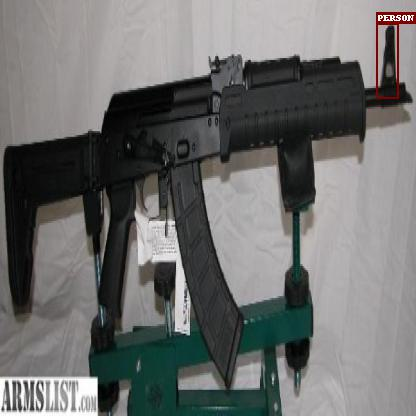

In [74]:
IPython.display.Image(filename='weapon10.jpg')

In [ ]:
cd ..

In [84]:
from IPython.display import FileLink
FileLink('./a-PyTorch-Tutorial-to-Object-Detection/checkpoint_ssd300.pth.tar')

/kaggle/working/a-PyTorch-Tutorial-to-Object-Detection/checkpoint_ssd300.pth.tar

<a href="./checkpoint_ssd300.pth.tar"> Download File </a>

In [87]:
pwd

'/kaggle/working'

In [89]:
# %load ./a-PyTorch-Tutorial-to-Object-Detection/datasets.py
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from utils import transform


class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.upper()

        assert self.split in {'TRAIN', 'TEST'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        # Read image
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')

        # Read objects in this image (bounding boxes, labels, difficulties)
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # (n_objects)
        difficulties = torch.ByteTensor(objects['difficulties'])  # (n_objects)

        # Discard difficult objects, if desired
        if not self.keep_difficult:
            boxes = boxes[1 - difficulties]
            labels = labels[1 - difficulties]
            difficulties = difficulties[1 - difficulties]

        # Apply transformations
        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, split=self.split)

        return image, boxes, labels, difficulties

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

        This describes how to combine these tensors of different sizes. We use lists.

        Note: this need not be defined in this Class, can be standalone.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each


[Errno 2] No such file or directory: 'a-PyTorch-Tutorial-to-Object-Detection'
/kaggle/working/a-PyTorch-Tutorial-to-Object-Detection


In [ ]:
try:
    !zip  ObjectDetection.zip './a-PyTorch-Tutorial-to-Object-Detection/'
except:
    print("An exception occurred")